just a small difference from dcgan , we use mse loss in training loop...


In [1]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

os.makedirs('./images/lsgan', exist_ok=True)

In [2]:
np.random.seed(1234)
torch.manual_seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
BATCH_SIZE  = 64
N_EPOCHS = 15
IMAGE_SIZE = 64
LATENT_DIM = 100
PRINT_EVERY = 5
N_SHOW = 5

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [6]:
data = datasets.CIFAR10('.data',
                        train=True,
                        download=True,
                        transform=transforms,
                        )

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting .data/cifar-10-python.tar.gz to .data


In [7]:
iterator = DataLoader(data,
                      batch_size=BATCH_SIZE,
                      shuffle=True
                     )

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size):
        super().__init__()

        self.main = nn.Sequential(

            nn.ConvTranspose2d(in_channels=latent_dim,
                               out_channels=image_size*8,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=image_size*8,
                               out_channels=image_size*4,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=image_size*4,
                               out_channels=image_size*2,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=image_size*2,
                               out_channels=image_size,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=image_size,
                               out_channels=3,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),

            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.main = nn.Sequential(

            nn.Conv2d(in_channels=3,
                      out_channels=image_size,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=image_size,
                      out_channels=image_size*2,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=image_size*2,
                      out_channels=image_size*4,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=image_size*4,
                      out_channels=image_size*8,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=image_size*8,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),

            #no sigmoid!
            #nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

In [11]:
G = Generator(LATENT_DIM, IMAGE_SIZE).to(device)

In [12]:
D = Discriminator(IMAGE_SIZE).to(device)

In [13]:
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [14]:
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [15]:
#don't use BCE loss!
#criterion = nn.BCELoss()

In [16]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [17]:
#labels
real_labels = torch.ones(BATCH_SIZE,).to(device)
fake_labels = torch.zeros(BATCH_SIZE,).to(device)

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

| Epoch: 005 | D_error: 0.089 | G_error: 0.585 | Time: 1m 42s


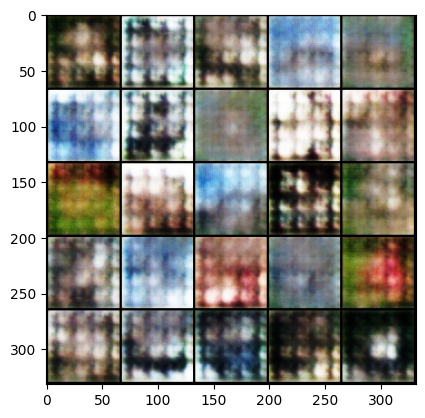

| Epoch: 010 | D_error: 0.273 | G_error: 0.170 | Time: 1m 42s


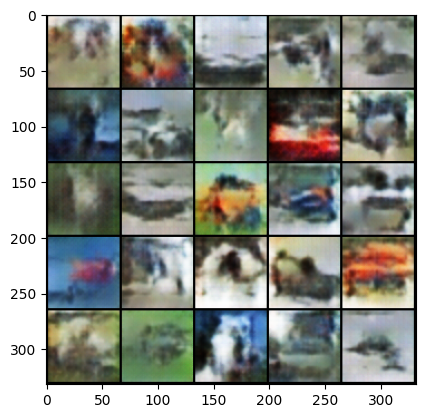

| Epoch: 015 | D_error: 0.022 | G_error: 0.378 | Time: 1m 42s


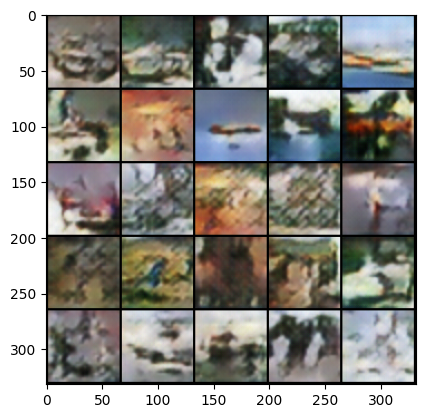

In [19]:
for epoch in range(1, N_EPOCHS+1):

    start_time = time.time()

    for _ in range(len(iterator)):

        #=====================#
        # TRAIN DISCRIMINATOR #
        #=====================#

        #zero discriminator gradients
        D.zero_grad()

        #get batch of real images
        x, _ = next(iter(iterator))

        #place images on GPU
        x = x.to(device)

        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)

        #generate images
        with torch.no_grad():
            generated_images = G(z)

        #put real images through discriminator
        pred_real = D(x)

        #how well does the discriminator detect real images?
        D_error_real = 0.5 * torch.mean((pred_real - real_labels) ** 2)

        #put fake images through the discriminator
        #need to detach so don't backpropagate through generator
        pred_fake = D(generated_images.detach())

        #how well does the discriminator detect fake images?
        D_error_fake = 0.5 * torch.mean((pred_fake - fake_labels) ** 2)

        #get discriminator error
        D_error = D_error_real + D_error_fake

        #backpropagate errors to get gradients
        D_error.backward()

        #use gradient to update discriminator parameters
        D_optimizer.step()

        #=================#
        # TRAIN GENERATOR #
        #=================#

        #zero generator gradients
        G.zero_grad()

        #get batch of real images
        x, _ = next(iter(iterator))

        #place images on GPU
        x = x.to(device)

        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)

        #generate images
        generated_images = G(z)

        #put fake images through the discriminator
        pred_fake = D(generated_images)

        #how well does the generator fool the discriminator?
        G_error = 0.5 * torch.mean((pred_fake - real_labels)**2)

        #backpropagate errors to get gradients
        G_error.backward()

        #use gradient to update generator parameters
        G_optimizer.step()

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch % PRINT_EVERY) == 0:

        #sample noise
        z = torch.randn(N_SHOW*N_SHOW, LATENT_DIM, 1, 1).to(device)

        #generate images
        with torch.no_grad():
            generated_images = G(z)

        print(f'| Epoch: {epoch:03} | D_error: {D_error.item():.03f} | G_error: {G_error.item():.03f} | Time: {epoch_mins}m {epoch_secs}s')

        #save N_SHOW*N_SHOW images
        torchvision.utils.save_image(generated_images,
                                     f'images/lsgan/epoch{epoch:03}.png',
                                     nrow=N_SHOW,
                                     normalize=True)

        #display images
        img = plt.imread(f'images/lsgan/epoch{epoch:03}.png')
        plt.imshow(img)
        plt.show()